# Final Report: MLB Pitching Data

## Executive Summary

Our MLB project looks at a variety of pitching statistics for each year a pitcher played throughout the course of their lifetime. Included in this data are stats such as Earned Run Average (a traditional pitcher stats that averages the number of runs given up by a pitcher in a full game), Opponent Batting Average (what percent of batters get a hit), salary, and their years of experience. The salary of MLB pitchers has been gradually incerasing over time (see graph), so seeing what factors effect salary gives an insight into the driving forces behind pitchers salary. Using individual pitcher statisticts, we have created a machine learning model that predicts most acurately their lifetime career earnings. This predictor reveals to teams and pitchers alike the most impactful staisticts on salary and what they should expect to pay players of certain caliber. This can improve player decision when accepting offers as well as a teams decision in who they should offer contracts too and furthermore how that salary offer will grow in their lifetime. 

## Introduction

Within the world of Major League Baseball, staistics and analysis is done on nearly everything. However it is true that money is really at the center of it all. Therefore, understanding on a statistical level what goes into a pitchers salary and additionally the recognition they will recieve through awards, is majorly important when making decisions both from a team perspective and as an individual pitcher. Therefore, the overarching goal of our project is to build a predictor for how successful pitchers can be in their career so that they can make better informed trade and contract decisions. 

We will use our dataset to determine which factors are most important in determining player salary and awards recieved. This will give them the advantage of better understanding the moneyball side of baseball. For our prediction analysis we will use Random Forest Regressors in order to predict each individual pitchers salary by year, culmulative career salaries, and award winning possibilities. We will also analyzie and adapt based on which pitcher stats in our dataset are most impactful. 

## Data Description

### Pre-processing Steps

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns 
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# pitching dataset 
df_pitching = pd.read_csv("Pitching.csv")
df_pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,NaN,NaN,NaN,0,NaN,NaN,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,NaN,NaN,NaN,0,NaN,NaN,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,NaN,NaN,NaN,0,NaN,NaN,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,NaN,NaN,NaN,0,NaN,NaN,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,NaN,NaN,NaN,0,NaN,NaN,21,NaN,NaN,NaN


In [2]:
# filter yearid is greater than 2000
pitching2000 = df_pitching[df_pitching['yearID'] >= 2000]

# group by player id and sum the bfp (batters faced) == total number of hitters faced by each player over carrer
faced = pitching2000.groupby("playerID").agg({"BFP": "sum"}).reset_index()

# filter faced at least 500 hitters
faced_500 = faced[faced['BFP'] >= 500]

# merging dataframe back 
df_filtered_pitching = pd.merge(pitching2000, faced_500['playerID'], on="playerID", how="inner")

# sort by playerID and yearID in ascending order
df_filtered_pitching.sort_values(["playerID", 'yearID'], inplace=True)
df_filtered_pitching = df_filtered_pitching.drop(['GIDP'], axis=1)

# has all players (in every season that they play and their stats for that season)
df_filtered_pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF
4656,aardsda01,2004,1,SFN,NL,1,0,11,0,0,...,6.75,0.0,0.0,2.0,0,61.0,5.0,8,0.0,1.0
4657,aardsda01,2006,1,CHN,NL,3,0,45,0,0,...,4.08,0.0,1.0,1.0,0,225.0,9.0,25,1.0,3.0
4658,aardsda01,2007,1,CHA,AL,2,1,25,0,0,...,6.40,3.0,2.0,1.0,0,151.0,7.0,24,2.0,1.0
4659,aardsda01,2008,1,BOS,AL,4,2,47,0,0,...,5.55,2.0,3.0,5.0,0,228.0,7.0,32,3.0,2.0
4660,aardsda01,2009,1,SEA,AL,3,6,73,0,0,...,2.52,3.0,2.0,0.0,0,296.0,53.0,23,2.0,1.0


In [3]:
# add a "traded" column
df_filtered_pitching["traded"] = df_filtered_pitching["teamID"] != df_filtered_pitching["teamID"].shift(1)

# boolean true or false 
traded_pitchers = df_filtered_pitching[df_filtered_pitching["traded"]]

# traded_pitchers is only players changed teams in consecutive years 
traded_pitchers.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,traded
4656,aardsda01,2004,1,SFN,NL,1,0,11,0,0,...,0.0,0.0,2.0,0,61.0,5.0,8,0.0,1.0,True
4657,aardsda01,2006,1,CHN,NL,3,0,45,0,0,...,0.0,1.0,1.0,0,225.0,9.0,25,1.0,3.0,True
4658,aardsda01,2007,1,CHA,AL,2,1,25,0,0,...,3.0,2.0,1.0,0,151.0,7.0,24,2.0,1.0,True
4659,aardsda01,2008,1,BOS,AL,4,2,47,0,0,...,2.0,3.0,5.0,0,228.0,7.0,32,3.0,2.0,True
4660,aardsda01,2009,1,SEA,AL,3,6,73,0,0,...,3.0,2.0,0.0,0,296.0,53.0,23,2.0,1.0,True


In [4]:
# load salaries data
df_salaries = pd.read_csv("Salaries.csv")

# filter the rows by years after 2000
salaries_df = df_salaries[df_salaries['yearID'] >= 2000]
salaries_df.head()

,yearID,teamID,lgID,playerID,salary
12263,2000,ANA,AL,anderga01,3250000
12264,2000,ANA,AL,belchti01,4600000
12265,2000,ANA,AL,botteke01,4000000
12266,2000,ANA,AL,clemeed02,215000
12267,2000,ANA,AL,colanmi01,200000


In [5]:
# summed salaries: for every player the salary is summed so it is their lifetime earnings
salaries_summed = salaries_df.groupby('playerID').sum().reset_index()
salaries_summed.head()

,playerID,yearID,salary
0,aardsda01,14061,9259750
1,abadan01,2006,327000
2,abadfe01,8052,2516400
3,abbotje01,4001,555000
4,abbotku01,4001,1100000


In [6]:
# updated dataframe: every pitchers season and the salary earned for that season 
pitchers_all_years = pd.merge(df_filtered_pitching, salaries_df[['playerID', 'yearID', 'teamID', 'salary']], on=['playerID', 'yearID', 'teamID'])
pitchers_all_years.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,WP,HBP,BK,BFP,GF,R,SH,SF,traded,salary
0,aardsda01,2004,1,SFN,NL,1,0,11,0,0,...,0.0,2.0,0,61.0,5.0,8,0.0,1.0,True,300000
1,aardsda01,2007,1,CHA,AL,2,1,25,0,0,...,2.0,1.0,0,151.0,7.0,24,2.0,1.0,True,387500
2,aardsda01,2008,1,BOS,AL,4,2,47,0,0,...,3.0,5.0,0,228.0,7.0,32,3.0,2.0,True,403250
3,aardsda01,2009,1,SEA,AL,3,6,73,0,0,...,2.0,0.0,0,296.0,53.0,23,2.0,1.0,True,419000
4,aardsda01,2010,1,SEA,AL,0,6,53,0,0,...,2.0,2.0,0,202.0,43.0,19,7.0,1.0,False,2750000


In [7]:
# calculating years of experience of players 

# making a copy so that it doesnt update the orig dataframe!
pitchers = df_filtered_pitching

# loop for each player 
for player in pitchers['playerID'].unique():
    # for each player
    player_row =pitchers[pitchers['playerID'] == player]
    
    # min year - max year
    min_player = player_row['yearID'].min()
    max_player = player_row['yearID'].max()
    diff = max_player - min_player + 1
    
    # add to df
    pitchers.loc[pitchers['playerID'] == player, 'experience'] = diff

pitchers.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,WP,HBP,BK,BFP,GF,R,SH,SF,traded,experience
4656,aardsda01,2004,1,SFN,NL,1,0,11,0,0,...,0.0,2.0,0,61.0,5.0,8,0.0,1.0,True,12.0
4657,aardsda01,2006,1,CHN,NL,3,0,45,0,0,...,1.0,1.0,0,225.0,9.0,25,1.0,3.0,True,12.0
4658,aardsda01,2007,1,CHA,AL,2,1,25,0,0,...,2.0,1.0,0,151.0,7.0,24,2.0,1.0,True,12.0
4659,aardsda01,2008,1,BOS,AL,4,2,47,0,0,...,3.0,5.0,0,228.0,7.0,32,3.0,2.0,True,12.0
4660,aardsda01,2009,1,SEA,AL,3,6,73,0,0,...,2.0,0.0,0,296.0,53.0,23,2.0,1.0,True,12.0


### Final Dataframe: average stats for each pitcher and lifetime earned salary

In [8]:
# new df for average pitcher stats

# using group by to avg over each unique player
pitchers_avg_stats = df_filtered_pitching.groupby('playerID').mean()

# create column (wpb: walks per batter) to show what percentage of the time the pitcher walks the batter
pitchers_avg_stats['wpb'] = pitchers_avg_stats['BB'] / pitchers_avg_stats['BFP']

# create column (hpb: hits per batter) to show what percentage of the time the pitcher lets up a hit
pitchers_avg_stats['hpb'] = pitchers_avg_stats['H'] / pitchers_avg_stats['BFP']

# create column (winp: win percentage) to show what percentage of the time the pitcher earns a win compared to a loss
pitchers_avg_stats['winp'] = pitchers_avg_stats['W'] / (pitchers_avg_stats['W'] + pitchers_avg_stats['L'])

# adding salary!!!! 
pitchers = pd.merge(pitchers_avg_stats, salaries_summed[['playerID', 'salary']], on=['playerID'])
pitchers.head()

,playerID,yearID,stint,W,L,G,GS,CG,SHO,SV,...,GF,R,SH,SF,traded,experience,wpb,hpb,winp,salary
0,aardsda01,2009.333333,1.000000,1.777778,2.000000,36.777778,0.000000,0.000000,0.0,7.666667,...,15.666667,18.777778,1.888889,1.222222,0.888889,12.0,0.124068,0.200678,0.470588,9259750
1,abadfe01,2012.500000,1.000000,0.833333,3.333333,43.000000,1.000000,0.000000,0.0,0.000000,...,11.000000,16.500000,1.166667,1.500000,0.500000,6.0,0.079381,0.226804,0.200000,2516400
2,abbotpa01,2002.333333,1.166667,5.166667,4.500000,16.666667,14.333333,0.166667,0.0,0.000000,...,0.500000,51.500000,1.333333,2.000000,0.666667,5.0,0.118964,0.220369,0.534483,6010000
3,accarje01,2008.600000,1.200000,1.000000,2.000000,26.200000,0.000000,0.000000,0.0,3.800000,...,11.500000,14.300000,0.500000,1.300000,0.500000,8.0,0.090835,0.235679,0.333333,3274400
4,aceveal01,2011.000000,1.000000,4.428571,2.285714,29.142857,2.142857,0.000000,0.0,4.142857,...,13.000000,24.571429,0.857143,1.857143,0.428571,7.0,0.080675,0.208255,0.659574,4285650


In [9]:
# awards data
awards_df = pd.read_csv('AwardsPlayers.csv')
awards_df.head()

,playerID,awardID,yearID,lgID,tie,notes
0,bondto01,Pitching Triple Crown,1877,NL,NaN,NaN
1,hinespa01,Triple Crown,1878,NL,NaN,NaN
2,heckegu01,Pitching Triple Crown,1884,AA,NaN,NaN
3,radboch01,Pitching Triple Crown,1884,NL,NaN,NaN
4,oneilti01,Triple Crown,1887,AA,NaN,NaN


In [10]:
# create dictionary explaining features in awards data
awards_dict = {}
awards_dict["playerID"] = "The first five letters of the pitchers last name,then the first two letters of their first name, followed by a number starting from 01 and increasing for each repeated name."
awards_dict["awardID"] = "The name of the award won by the player"
awards_dict["yearID"] = "The year represented that the player pitched in."
awards_dict["lgID"] = "League that the team is a part of."
awards_dict["tie"] = "If there was a tie for the award (Y or null)"
awards_dict["notes"] = "Any notes about this award"

awards_dict

{'playerID': 'The first five letters of the pitchers last name,then the first two letters of their first name, followed by a number starting from 01 and increasing for each repeated name.',
 'awardID': 'The name of the award won by the player',
 'yearID': 'The year represented that the player pitched in.',
 'lgID': 'League that the team is a part of.',
 'tie': 'If there was a tie for the award (Y or null)',
 'notes': 'Any notes about this award'}

In [11]:
# pitchers data with salaries
pitchers

,playerID,yearID,stint,W,L,G,GS,CG,SHO,SV,...,GF,R,SH,SF,traded,experience,wpb,hpb,winp,salary
0,aardsda01,2009.333333,1.000000,1.777778,2.000000,36.777778,0.000000,0.000000,0.000000,7.666667,...,15.666667,18.777778,1.888889,1.222222,0.888889,12.0,0.124068,0.200678,0.470588,9259750
1,abadfe01,2012.500000,1.000000,0.833333,3.333333,43.000000,1.000000,0.000000,0.000000,0.000000,...,11.000000,16.500000,1.166667,1.500000,0.500000,6.0,0.079381,0.226804,0.200000,2516400
2,abbotpa01,2002.333333,1.166667,5.166667,4.500000,16.666667,14.333333,0.166667,0.000000,0.000000,...,0.500000,51.500000,1.333333,2.000000,0.666667,5.0,0.118964,0.220369,0.534483,6010000
3,accarje01,2008.600000,1.200000,1.000000,2.000000,26.200000,0.000000,0.000000,0.000000,3.800000,...,11.500000,14.300000,0.500000,1.300000,0.500000,8.0,0.090835,0.235679,0.333333,3274400
4,aceveal01,2011.000000,1.000000,4.428571,2.285714,29.142857,2.142857,0.000000,0.000000,4.142857,...,13.000000,24.571429,0.857143,1.857143,0.428571,7.0,0.080675,0.208255,0.659574,4285650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,zieglbr01,2011.444444,1.111111,3.333333,2.333333,59.444444,0.000000,0.000000,0.000000,7.000000,...,19.666667,18.555556,1.555556,1.888889,0.222222,8.0,0.084500,0.214286,0.588235,16510000
1154,zimmeje02,2000.500000,1.000000,4.000000,4.500000,65.500000,0.000000,0.000000,0.000000,14.500000,...,35.000000,32.000000,2.000000,3.000000,0.500000,2.0,0.083893,0.214765,0.470588,10557501
1155,zimmejo02,2012.000000,1.000000,10.000000,7.142857,25.428571,25.428571,1.142857,0.571429,0.000000,...,0.000000,62.714286,6.285714,2.714286,0.142857,7.0,0.049231,0.233237,0.583333,32065000
1156,zitoba01,2007.066667,1.000000,11.000000,9.533333,28.866667,28.066667,0.800000,0.333333,0.000000,...,0.600000,83.600000,7.000000,4.866667,0.200000,16.0,0.096718,0.216435,0.535714,137035000


In [12]:
# create dictionary explaining features in pitching data
pitching_dict = {}
pitching_dict["playerID"] = "The first five letters of the pitchers last name,then the first two letters of their first name, followed by a number starting from 01 and increasing for each repeated name."
pitching_dict["yearID"] = "The year represented that the player pitched in."
pitching_dict["teamID"] = "Team that the player is on represented by a 3 letter symbol."
pitching_dict["IgID"] = "Conference that the team is a part of."
pitching_dict["W"] = "Number of wins."
pitching_dict["L"] = "Number of losses."
pitching_dict["G"] = "Number of Games."
pitching_dict["GS"] = "Number of Games Started."
pitching_dict["CG"] = "Number of complete games pitched."
pitching_dict["SHO"] = "Number of complete games that were a shutout."
pitching_dict["SV"] = "Number of saves."
pitching_dict["IPouts"] = "Number of innins pitched with outs as a decimal."
pitching_dict["H"] = "The number of hits the pitcher allowed."
pitching_dict["ER"] = "Number of Earned Runs."
pitching_dict["BB"] = "Number of walks."
pitching_dict["SO"] = "Number of strikeouts."
pitching_dict["BAOpp"] = "Batting average of the opponent."
pitching_dict["ERA"] = "Earned Run Average."
pitching_dict["IBB"] = "Intentional Walks."
pitching_dict["WP"] = "Amount of Wild Pitches."
pitching_dict["HBP"] = "Amount of Hit by Pitches."
pitching_dict["BK"] = "Amount of Balks"
pitching_dict["BFP"] = "Batters faced by Pitcher."
pitching_dict["GF"] = "Games Finished."
pitching_dict["R"] = "Runs Allowed"
pitching_dict["SH"] = "Sacraficed Hits Allowed"
pitching_dict["SF"] = "Sacrafice Flies Allowed."
pitching_dict["traded"] = "The average amount of tiems a player was traded in a year."
pitching_dict["experience"] = "Amount of years played."
pitching_dict["wpb"] = "Walks Per Batter"
pitching_dict["hpb"] = "Hits Per Batter"
pitching_dict["winp"] = "Win Percentage"
pitching_dict["salary"] = "Total earnings over their career in baseball"

pitching_dict



{'playerID': 'The first five letters of the pitchers last name,then the first two letters of their first name, followed by a number starting from 01 and increasing for each repeated name.',
 'yearID': 'The year represented that the player pitched in.',
 'teamID': 'Team that the player is on represented by a 3 letter symbol.',
 'IgID': 'Conference that the team is a part of.',
 'W': 'Number of wins.',
 'L': 'Number of losses.',
 'G': 'Number of Games.',
 'GS': 'Number of Games Started.',
 'CG': 'Number of complete games pitched.',
 'SHO': 'Number of complete games that were a shutout.',
 'SV': 'Number of saves.',
 'IPouts': 'Number of innins pitched with outs as a decimal.',
 'H': 'The number of hits the pitcher allowed.',
 'ER': 'Number of Earned Runs.',
 'BB': 'Number of walks.',
 'SO': 'Number of strikeouts.',
 'BAOpp': 'Batting average of the opponent.',
 'ERA': 'Earned Run Average.',
 'IBB': 'Intentional Walks.',
 'WP': 'Amount of Wild Pitches.',
 'HBP': 'Amount of Hit by Pitches.'

# Visualizations

/var/folders/1r/ckvf6t0n45x4lqxvckk9wcth0000gn/T/ipykernel_72792/601504775.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label = 'win percentage')


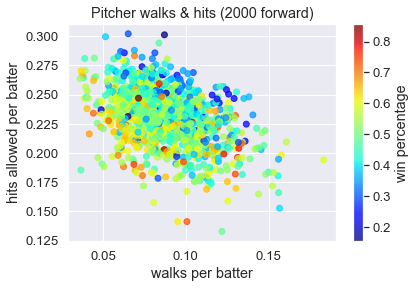

In [13]:
# display how walks and hits lead to pitcher's win percentage

# assign columns to variables for graphing
wpb = pitchers['wpb']
hpb = pitchers['hpb']
winp = pitchers['winp']

# plot
sns.set(font_scale = 1.2)
plt.scatter(wpb, hpb, alpha = 0.75, c = winp, cmap = 'jet')
plt.xlabel('walks per batter')
plt.ylabel('hits allowed per batter')
plt.title('Pitcher walks & hits (2000 forward)')
plt.colorbar(label = 'win percentage')

The initial visualization, seen above, plots each pitcher's walks and hits allowed since 2000 (up until 2015) and then color coats the dots based on the win percentage (higher win percentage is redder, lower is bluer). The trend appears to be that the lower the walk and hits allowed the higher the win percentage and the higher the walk and hits allowed the lower the win percentage, however the correlation does not seem to be strong.


0.09518253412187527

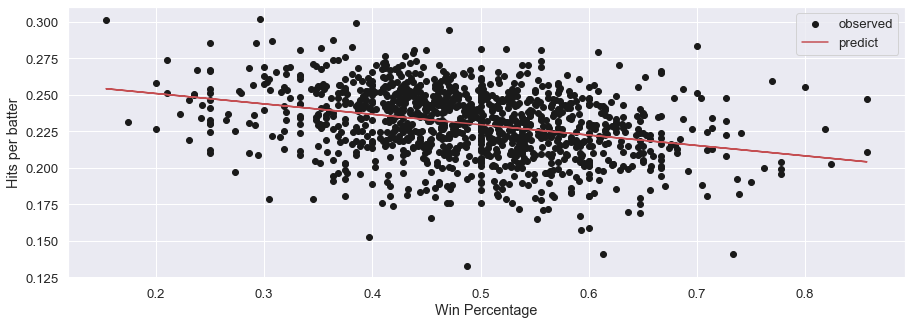

In [14]:
# create regression showing relationship between hits and pitcher's win percentage

# cleans up the plot using seaborn
sns.set(font_scale=1.2)

# extracts and saves the x and y_true values for the regressor
x = pitchers.loc[:, 'winp'].values
y_true = pitchers.loc[: ,'hpb'].values

# x must be 2 dimensional with shape: (n_samples, n_features)
x = x.reshape(-1, 1)

# fit and predict regression model
reg = LinearRegression()
reg.fit(x, y_true)
y_pred = reg.predict(x)

# calculate r2 score
r2 = r2_score(y_true=y_true, y_pred=y_pred)
    
# plot and label the graph (as well as legend)
plt.scatter(x, y_true, label='observed', color= 'k')
plt.plot(x, y_pred, label='predict', color='r')
plt.xlabel('Win Percentage')
plt.ylabel('Hits per batter')
plt.legend()
plt.gcf().set_size_inches(15, 5)
r2

This visualization, seen above, plots out each pitcher's win percentage and their hits per batter and runs a regressor on the data and plots out the line of best fit. These are just the pitchers since 2000 (up until 2015). The regressor however has a decently low r2 which led to us making the new visualizations that follow

### Pitching Statistics effect on Awards

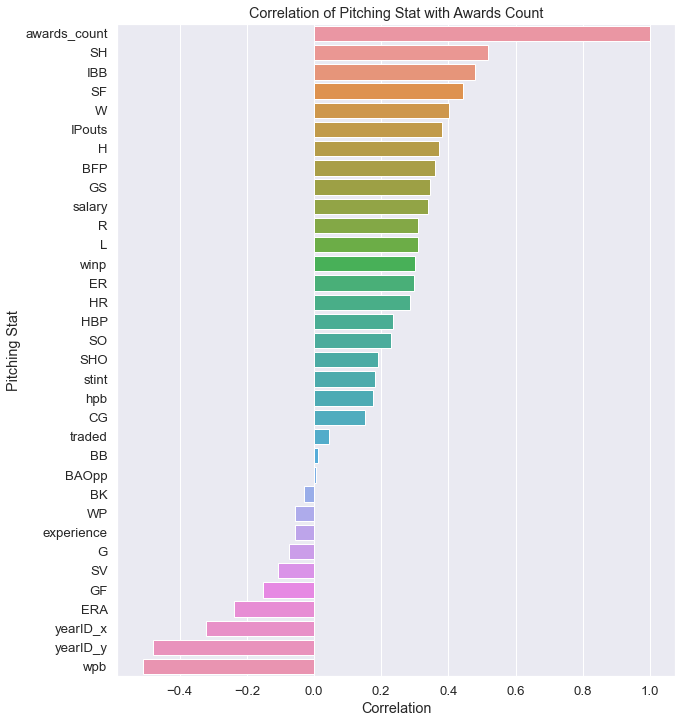

In [15]:
# create visualization

# Merge the two datasets based on the playerID column
merged_df = pd.merge(pitchers, awards_df, on='playerID', how='inner')

# Group the merged dataset by playerID and awardID, and count the number of awards won by each player
awards_count = merged_df.groupby(['playerID', 'awardID']).size().reset_index(name='awards_count')
awards_count = awards_count.groupby('playerID')['awards_count'].sum().reset_index()

# Merge the awards_count dataframe with the merged_df dataframe
merged_df = pd.merge(merged_df, awards_count, on='playerID', how='left')

# Calculate the correlation matrix between all the numeric columns in the merged dataset
corr_matrix = merged_df.corr()

# Create a bar plot of the correlation values between the awards_count column and all the other columns
awards_corr = corr_matrix['awards_count'].sort_values(ascending=False)
plt.figure(figsize=(10, 12))
sns.barplot(x=awards_corr.values, y=awards_corr.index)
plt.title('Correlation of Pitching Stat with Awards Count')
plt.xlabel('Correlation')
plt.ylabel('Pitching Stat')
plt.show()

This visualization quantifies the relationship between various pitching metrics and the likelihood of a pitcher receiving an award. It calculates the correlation coefficient of each statistic with award success and plots it on the bar graph. By visualizing these correlations, the graph shows the most important metrics on a pitcher's award chances.

### Visualizing how salaries have changed over time 

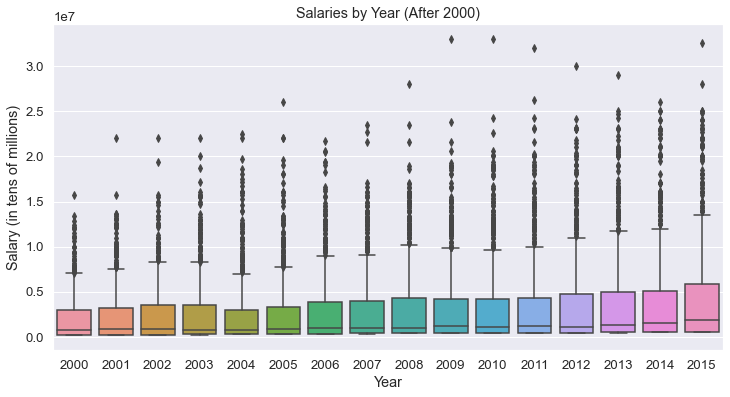

In [16]:
# create visualization displaying how salaries have changed over time

sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))

# Filter the salaries data to only include years after 2000
salaries_after_2000 = salaries_df[salaries_df['yearID'] >= 2000]

sns.boxplot(data=salaries_after_2000, x='yearID', y='salary')
plt.title('Salaries by Year (After 2000)')
plt.xlabel('Year')
plt.ylabel('Salary (in tens of millions)')
plt.show()

This visualization is a boxplot which shows how salaries have changed over time for Major League Baseball (MLB) players from 2000-2015. The y-axis displays the salary amount in tens of millions of dollars, while the x-axis displays the year. The boxplot shows the distribution of salaries for each year, with the median represented by the line inside the box, the first and third quartiles represented by the edges of the box, and outliers displayed as individual points. The visualization helps to identify any trends or patterns in the distribution of salaries over time and how both the measures of center and the ranges have increased.

## Methods

A variety of Machine Learning techniques are being displayed. First, we are using regression to see the correlation between win percentage and numerous major pitching statistics, though this turned out to be a relatively ineffective method, it helped us to determine our next steps. We eventually decided to use a random forest regressor to look at the feature importance of factors predicting accumulated salary. This is then taken one step further when it is paired with a predictive model that can predict the cumulative salary of a pitcher from their major statistics.

# Prediction Results

### Random Forest Regressor

In [17]:
# rename columns for so the reader can better interpret graphs
pitchers.rename(columns = {'W':'Wins', 'L':'Losses', 'G':'Games', 'GS': 'Games Started', 'CG':'Complete Games', 'SHO':'Shutouts', 'SV':'Saves', 'IPouts':'Innings Pitched w Outs', 'H':'Hits', 'ER':'Earned Runs', 'HR':'Home Runs', 'BB':'Walks', 'SO':'Strikeouts', 'BAOpp':'Opponent Batting Average', 'ERA':'Earned Run Average', 'IBB':'Intentional Walks', 'WP':'Wild Pitches', 'HBP':'Hit By Pitches', 'BK':'Balks', 'BFP':'Batters Faced By Pitcher', 'GF':'Games Finished', 'R':'Runs', 'SH':'Sacrificed Hits', 'SF':'Sacrificed Files', 'GIDP':'Ground Into Double Plays'}, inplace = True)

In [18]:
feature_list = ['playerID', 'yearID', 'stint', 'Wins', 'Losses', 'Games',
       'Games Started', 'Complete Games', 'Shutouts', 'Saves',
       'Innings Pitched w Outs', 'Hits', 'Earned Runs', 'Home Runs', 'Walks',
       'Strikeouts', 'Opponent Batting Average', 'Earned Run Average',
       'Intentional Walks', 'Wild Pitches', 'Hit By Pitches', 'Balks',
       'Batters Faced By Pitcher', 'Games Finished', 'Runs', 'Sacrificed Hits',
       'Sacrificed Files', 'traded', 'experience', 'wpb', 'hpb', 'winp',
       'salary']

In [19]:
x_feat_list = ['stint', 'Wins', 'Losses', 'Games', 'Games Started',
       'Complete Games', 'Shutouts', 'Saves',
       'Innings Pitched w Outs', 'Hits', 'Earned Runs', 'Home Runs', 'Walks',
       'Strikeouts', 'Opponent Batting Average', 'Earned Run Average',
       'Intentional Walks', 'Wild Pitches', 'Hit By Pitches', 'Balks',
       'Batters Faced By Pitcher', 'Games Finished', 'Runs', 'Sacrificed Hits',
       'Sacrificed Files', 'traded', 'experience']
x = pitchers.loc[:, x_feat_list].values
y = pitchers.loc[:, 'salary'].values

n_splits = 10

# kfold
kfold = KFold(n_splits = n_splits)

# build decision tree classifier
rfr = RandomForestRegressor()

# allocate an empty array to store predictions in
y_pred = np.empty_like(y)

for train_idx, test_idx in kfold.split(x, y):
    # build arrays which correspond to x, y train/test
    x_train = x[train_idx, :]
    y_train = y[train_idx]
    
    # x test
    x_test = x[test_idx, :]
    
    # fit data
    rfr = rfr.fit(x_train, y_train)
                     
    # estimate on test data
    y_pred[test_idx] = rfr.predict(x_test)

r2_score(y_true=y, y_pred=y_pred)

print('The r2 score of', x_feat_list, 'to salary is:', r2_score(y_true=y, y_pred=y_pred))

The r2 score of ['stint', 'Wins', 'Losses', 'Games', 'Games Started', 'Complete Games', 'Shutouts', 'Saves', 'Innings Pitched w Outs', 'Hits', 'Earned Runs', 'Home Runs', 'Walks', 'Strikeouts', 'Opponent Batting Average', 'Earned Run Average', 'Intentional Walks', 'Wild Pitches', 'Hit By Pitches', 'Balks', 'Batters Faced By Pitcher', 'Games Finished', 'Runs', 'Sacrificed Hits', 'Sacrificed Files', 'traded', 'experience'] to salary is: 0.7987901625308205


In [20]:
all_feats=pd.DataFrame(pitchers)

# predicted salary 
all_feats['prediction']=y_pred

# actual salary 
all_feats['salary']=[pitchers['salary'][index] for index in all_feats.reset_index()['index']]

# update dataframe
all_feats = all_feats[['Wins', 'Complete Games', 'Shutouts', 'Innings Pitched w Outs', 'Hits', 'Strikeouts', 'Batters Faced By Pitcher', 'experience', 'salary',
       'prediction']]

# calcualte differnce of predicted v actual 
all_feats['residual'] = all_feats['prediction'] - all_feats['salary']

# sort by excess
all_feats.sort_values(by = 'residual')

,Wins,Complete Games,Shutouts,Innings Pitched w Outs,Hits,Strikeouts,Batters Faced By Pitcher,experience,salary,prediction,residual
874,4.000000,0.000000,0.000000,194.357143,49.857143,59.714286,254.428571,14.0,163591725,64761005,-98830720
126,9.000000,1.000000,0.166667,412.833333,127.666667,116.000000,569.500000,6.0,94285716,11449243,-82836473
912,13.375000,2.375000,0.750000,560.375000,176.937500,160.875000,779.062500,15.0,193642856,121531521,-72111335
972,5.600000,0.600000,0.200000,317.600000,98.200000,98.600000,432.400000,9.0,94000001,28165462,-65834539
410,8.666667,0.888889,0.333333,408.444444,147.777778,76.222222,597.666667,11.0,116107270,52549975,-63557295
...,...,...,...,...,...,...,...,...,...,...,...
449,8.882353,2.294118,0.529412,468.647059,173.470588,93.882353,674.823529,13.0,47800000,81174760,33374760
705,11.444444,2.777778,1.111111,438.000000,150.222222,92.666667,618.000000,9.0,33432500,67465669,34033169
916,9.500000,1.333333,0.166667,441.666667,122.000000,168.500000,592.833333,6.0,11275000,47142071,35867071
135,12.142857,1.428571,0.714286,501.857143,147.571429,161.428571,678.571429,7.0,12426667,51372684,38946017


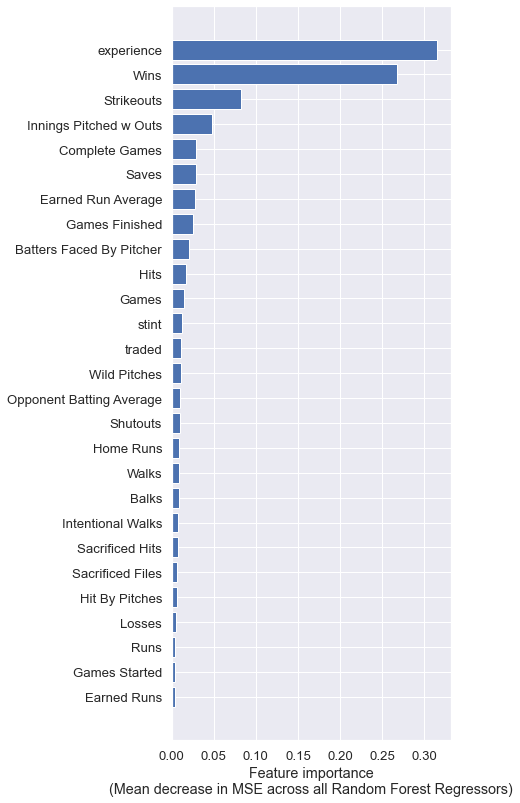

In [21]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean mse reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in MSE across all Random Forest Regressors)')


#plotting feature importance of enitre dataset 
plot_feat_import(x_feat_list, rfr.feature_importances_) 

This feature importance plot, seen above, reveals that a pitchers years of experience, number of wins, number of strikeouts, number of inning spitched with outs are some of the most important feautures for explaining the mean decrease in MSE across the random forest regression. This plot impacted which features to select when running the regressor again. 

Text(0.5, 1.0, 'Heatmap of Correlation Matrix for Baseball Data comparing all features in the dataset')

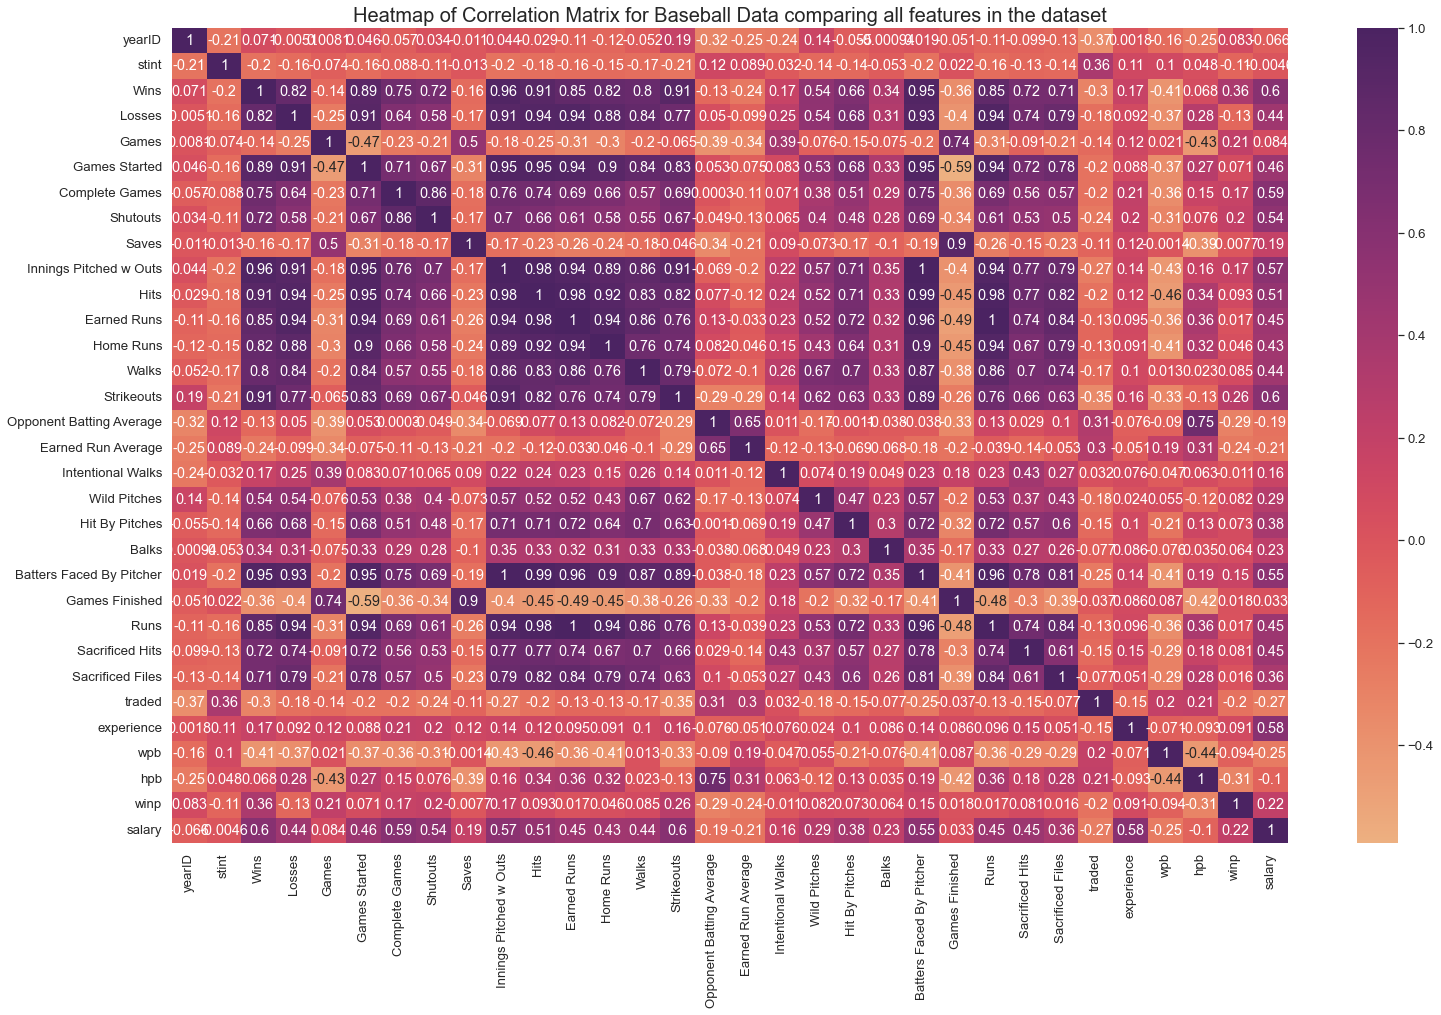

In [22]:
# all features in dataframe
cols_of_interest = feature_list

# correlation matrix
corr_matrix = pitchers[cols_of_interest].corr()

# create a heatmap
plt.figure(figsize=(25,15))
sns.heatmap(corr_matrix, annot=True, cmap='flare')

plt.title('Heatmap of Correlation Matrix for Baseball Data comparing all features in the dataset', fontsize=20)

The correlation matrix above compares all the feautres in the dataset to each other. Salary is in the far right column and the bottom row. Those features more highly correlated with salary have a darker purple color, less correlated features have a lighter orange color. 

### Run Random Forest Regressor Again with Most Important Features

In [23]:
# get only the most important features (have a correlation above 0.5)

# copy of dataframe 
threshold_df = pd.DataFrame(pitchers.corr()['salary']).reset_index()

# making new column which will be threshold > 0.5 
threshold_df['Threshold']=abs(threshold_df['salary'])>= 0.5

# only if correlation >= 0.5, feature will be added 
above_thresh = threshold_df[threshold_df['Threshold'] == True]

#feature list 
features = []
for index in above_thresh['index']:
    features.append(index)
print('Features with >= 0.5 correlation to Salary:', features)

Features with >= 0.5 correlation to Salary: ['Wins', 'Complete Games', 'Shutouts', 'Innings Pitched w Outs', 'Hits', 'Strikeouts', 'Batters Faced By Pitcher', 'experience', 'salary', 'prediction']


In [24]:
x_feat_list = ['Wins', 'Complete Games', 'Shutouts', 'Innings Pitched w Outs', 'Hits', 'Strikeouts', 'Batters Faced By Pitcher', 'experience']
x = pitchers.loc[:, x_feat_list].values
y = pitchers.loc[:, 'salary'].values

n_splits = 20

# kfold
kfold = KFold(n_splits = n_splits)

# build decision tree classifier
rfr =  RandomForestRegressor()

# allocate an empty array to store predictions in
y_pred = np.empty_like(y)

for train_idx, test_idx in kfold.split(x, y):
    # build arrays which correspond to x, y train/test
    x_train = x[train_idx, :]
    y_train = y[train_idx]
    
    #x test
    x_test = x[test_idx, :]
    
    # fit data
    rfr = rfr.fit(x_train, y_train)
                     
    # estimate on test data
    y_pred[test_idx] = rfr.predict(x_test)

r2_score(y_true=y, y_pred=y_pred)
print('The r2 score of', x_feat_list, 'to salary is:', r2_score(y_true=y, y_pred=y_pred))

The r2 score of ['Wins', 'Complete Games', 'Shutouts', 'Innings Pitched w Outs', 'Hits', 'Strikeouts', 'Batters Faced By Pitcher', 'experience'] to salary is: 0.7582607348483933


<AxesSubplot:title={'center':'Correlation Matrix of Filtered Stats (>= 0.5 correlation with salary)'}>

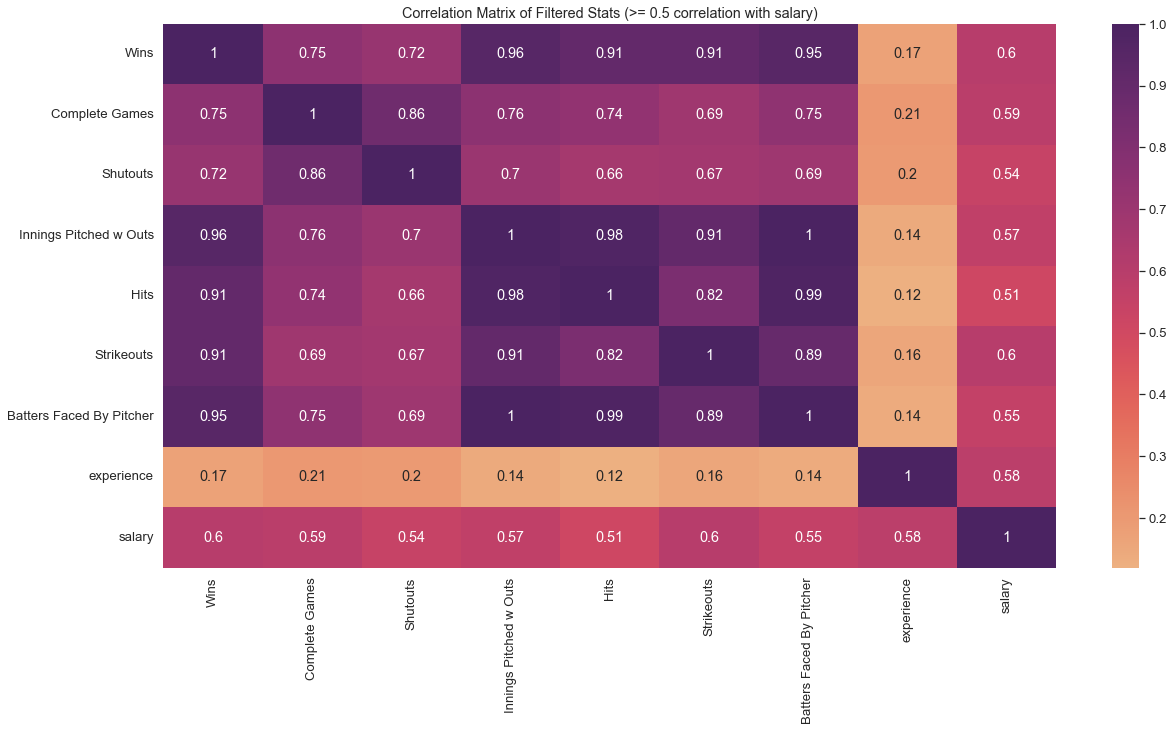

In [25]:
# features >= 0.5 correlation w salary
cols_of_interest = ['Wins', 'Complete Games', 'Shutouts', 'Innings Pitched w Outs', 'Hits', 'Strikeouts', 'Batters Faced By Pitcher', 'experience', 'salary']

# correlation matrix
corr_matrix = pitchers[cols_of_interest].corr()

# create a heatmap
plt.figure(figsize=(20,10))
plt.title('Correlation Matrix of Filtered Stats (>= 0.5 correlation with salary)')
sns.heatmap(corr_matrix, annot=True, cmap='flare')

The updated correlation matrix above compares the filtered feautres (>= 0.5 correlation w salary) in the dataset to each other. Salary is in the far right column and the bottom row. Those features more highly correlated with salary have a darker purple color, less correlated features have a lighter orange color. One thing to note here is that while experience, being light orange, does not look corelated with the other pitcher stats, this logically makes sense as some player may improve their stats thorughout their carrer and others may decline due to age and loss of ability, therefore this can be a somewhat random occurance depending on the pitcher. 

## Final Dataframe: adding predicted results back into dataframe

In [26]:
most_important=pd.DataFrame(pitchers)

# predicted salary
most_important['prediction']=y_pred

# actual sallary 
most_important['salary']=[pitchers['salary'][index] for index in most_important.reset_index()['index']]

# update new df 
most_important = most_important[['Wins', 'Complete Games', 'Shutouts', 'Innings Pitched w Outs', 'Hits', 
                                 'Strikeouts', 'Batters Faced By Pitcher', 'experience', 'salary', 'prediction']]

# calculate differnt between predicted and actual 
most_important['residual'] = most_important['prediction'] - most_important['salary']

# sort by difference 
most_important.sort_values(by='residual')

,Wins,Complete Games,Shutouts,Innings Pitched w Outs,Hits,Strikeouts,Batters Faced By Pitcher,experience,salary,prediction,residual
874,4.000000,0.000000,0.000000,194.357143,49.857143,59.714286,254.428571,14.0,163591725,30175562,-133416163
126,9.000000,1.000000,0.166667,412.833333,127.666667,116.000000,569.500000,6.0,94285716,17565930,-76719786
972,5.600000,0.600000,0.200000,317.600000,98.200000,98.600000,432.400000,9.0,94000001,22632192,-71367809
410,8.666667,0.888889,0.333333,408.444444,147.777778,76.222222,597.666667,11.0,116107270,45768449,-70338821
912,13.375000,2.375000,0.750000,560.375000,176.937500,160.875000,779.062500,15.0,193642856,126171939,-67470917
...,...,...,...,...,...,...,...,...,...,...,...
135,12.142857,1.428571,0.714286,501.857143,147.571429,161.428571,678.571429,7.0,12426667,47229198,34802531
559,7.100000,0.900000,0.300000,329.600000,115.200000,88.800000,475.400000,14.0,12929500,48056557,35127057
587,7.363636,0.454545,0.181818,368.363636,136.909091,78.636364,534.454545,13.0,11990000,47784665,35794665
705,11.444444,2.777778,1.111111,438.000000,150.222222,92.666667,618.000000,9.0,33432500,73670105,40237605


## Discussion

The results of our findings are impactful, but not ground-breaking. They take a new perspective on an issue that is commonly looked at. Though it would not be a surprise to any analysts, it could provide a useful tool when deciding what individuals need to work on most and a tool in predicting salaries and likelihood to win awards.

In our opinion, we can determine that more time pitched, more wins accumulated, and more strikeouts had are more impactful than largely looked at statistics such as ERA, OppBA and numerous others.  This means that the longevity and team success of a player is vitally important in accumulating a larger salary and giving a chance at winning awards, which can easily be justified. That being said, there is no major action that can be taken aside from increased physical therapy and other physical longevity increasing activities.

Our most salient ethical concern is related to players and encouraging them to play for long periods of time, when this may lead to their physical impairment and increase their overall chances at being injured. Though this is a risk in any sports related activity, it is to be noted as a possible ethical concern.